# Multi-region spot instance simulator

### Problem: you start in a region; figure out the policy on preemption  (i.e., to which region you switch, if any)?

* Assume: Preemption is a poisson process with probability p, different p for each region
* Assume: jobs are infinite length, with no checkpoint

### Not implemented yet
* Model for demand - and then we assume a fixed supply. And if the demand exceeds the supply in a region, there should be no availability. Note that preemption can also be be a function of this demand-supply relation. When there's high demand, there can be higher chance for preemption.

# Policies implemented
* Random - randomly picks a region
* Learning from history - Epsilon greedy

### Policies to add
* Stick to the same region (Where do you start?)

## What do we want to measure?
* Number of preemptions?
* Max progress made (max(time spent on a single region before getting preempted))

This is is assuming no checkpointing. If we assume checkpoint, then the above metrics may not be very meaningful.

In [17]:
from simulator import Environment, Job, Region, Scheduler
import matplotlib.pyplot as plt
import copy

## Define environment (job, region)

In [23]:
RUN_TIME = 200

def env1():
    # Returns a list of regions and jobs
    n_jobs = 2
    regions = [Region(name="r0", p=0.05), # Low preemption, ideal region
               Region(name="r1", p=0.2),
               Region(name="r2", p=0.2),
               Region(name="r3", p=0.2),
               Region(name="r4", p=0.2),
               Region(name="r5", p=0.2),
               Region(name="r6", p=0.2),
               Region(name="r7", p=0.2),
               Region(name="r8", p=0.2),
               Region(name="r9", p=0.2)]
    jobs = [Job(f"job{i}", None) for i in range(0, n_jobs)]
    return regions, jobs
    
def run_simulator(total_time, env_fn, policy) -> Environment:
    regions, jobs = env_fn()
    # Define environment
    env = Environment(regions, sched_policy=policy)
    for j in jobs:
        env.add_job(j)
    
    # Run simulator
    print("Running simulator")
    for i in range(total_time):
        env.tick()
        
    # Return env. Use env.jobs and env.regions to get job state
    return env

# Run simulator

In [24]:
random_env1 = run_simulator(RUN_TIME, env_fn=env1, policy='random')
eg_env1 = run_simulator(RUN_TIME, env_fn=env1, policy='epsilon_greedy')

Running simulator
t=1: Scheduled job0 to r7
t=1: Scheduled job1 to r6
t=3: Scheduled job1 to r7
t=4: Scheduled job0 to r8
t=5: Scheduled job0 to r5
t=6: Scheduled job1 to r1
t=8: Scheduled job0 to r4
t=10: Scheduled job1 to r4
t=12: Scheduled job0 to r8
t=13: Scheduled job1 to r3
t=14: Scheduled job0 to r8
t=15: Scheduled job0 to r2
t=15: Scheduled job1 to r4
t=23: Scheduled job0 to r1
t=23: Scheduled job1 to r3
t=31: Scheduled job0 to r5
t=33: Scheduled job0 to r9
t=35: Scheduled job0 to r5
t=37: Scheduled job1 to r7
t=39: Scheduled job1 to r4
t=46: Scheduled job1 to r2
t=50: Scheduled job0 to r2
t=52: Scheduled job1 to r7
t=53: Scheduled job0 to r2
t=54: Scheduled job1 to r6
t=60: Scheduled job0 to r7
t=61: Scheduled job0 to r4
t=62: Scheduled job1 to r0
t=65: Scheduled job0 to r1
t=73: Scheduled job0 to r1
t=74: Scheduled job0 to r6
t=77: Scheduled job0 to r9
t=77: Scheduled job1 to r9
t=83: Scheduled job1 to r3
t=86: Scheduled job1 to r8
t=89: Scheduled job1 to r0
t=90: Scheduled j

In [50]:
def compute_segment_lengths(jobs):
    jobwise_seg_lengths = {}
    for job in jobs:
        hist = job.history
        segment_lengths = {}
        curr_seg = hist[0]
        curr_seg_len = 0
        for i in range(0, len(hist)):
            # If name of region is the same
            if hist[i][1] == curr_seg[1]:
                curr_seg_len += 1
            else:
                segment_lengths[curr_seg] = curr_seg_len
                curr_seg = hist[i]
                curr_seg_len = 1
        segment_lengths[curr_seg] = curr_seg_len
        jobwise_seg_lengths[job] = segment_lengths
    return jobwise_seg_lengths

def plot_max_progress(jobs):
    # Progress is the time spent on a region before getting preempted
    plt.figure(figsize=(5, 3), dpi=150)
    heights = []
    ids = []
    str_ids = []
    seg_lengths = compute_segment_lengths(jobs)
    for i, job in enumerate(jobs):
        heights.append(max(seg_lengths[job].values()))
        ids.append(i)
        str_ids.append(job.name)
    plt.bar(ids, heights, align='center')
    plt.xticks(ids, str_ids)
    plt.ylim([0, RUN_TIME])
    plt.ylabel('Max progress made')
    plt.xlabel('Jobs')


def plot_timeline(jobs, regions):
    plt.figure(figsize=(5, 3), dpi=150)
    sorted_regions = [r.name for r in sorted(regions, key=lambda k: k.name)]
    region_ints = list(range(0, len(sorted_regions)))
    region_to_ints = dict(zip(sorted_regions, region_ints))
    print(region_to_ints)
    for job in jobs:
        hist = copy.deepcopy(job.history)
        x_data = []
        y_data = []
        x_data, y_data = map(list, zip(*hist))
        y_data_int = [region_to_ints[region_str] for region_str in y_data]
        plt.plot(x_data, y_data_int, label=job.name)
    plt.title('Simulator timeline')
    plt.ylabel('Region')
    plt.xlabel('Time')
    plt.yticks(region_ints, sorted_regions)
    plt.legend()

def plot_num_preemptions(jobs):
    plt.figure(figsize=(5, 3), dpi=150)
    heights = []
    ids = []
    str_ids = []
    for i, job in enumerate(jobs):
        heights.append(job.num_preemptions)
        ids.append(i)
        str_ids.append(job.name)
    plt.bar(ids, heights, align='center')
    plt.xticks(ids, str_ids)
    plt.ylabel('Number of preemptions')
    plt.xlabel('Jobs')
    plt.ylim([0, 50])

Text(0.5, 1.0, 'Max Progress - Epsilon-Greedy Policy')

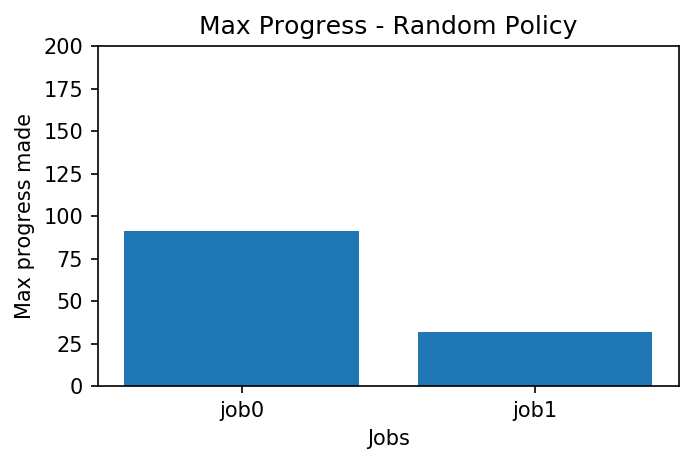

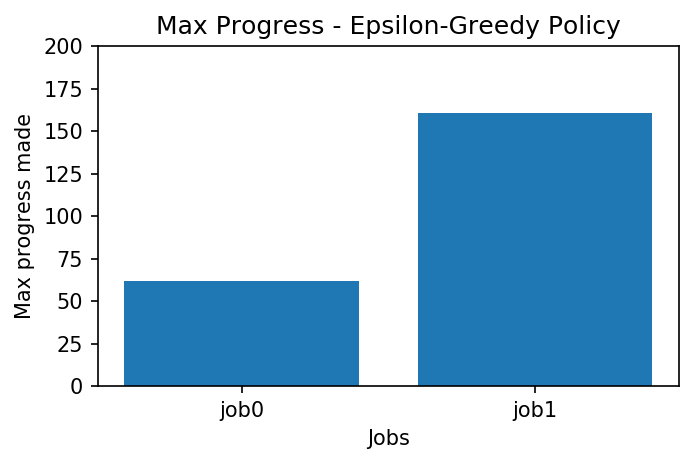

In [51]:
plot_max_progress(random_env1.jobs)
plt.title("Max Progress - Random Policy")

plot_max_progress(eg_env1.jobs)
plt.title("Max Progress - Epsilon-Greedy Policy")

{'r0': 0, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9}
{'r0': 0, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9}


Text(0.5, 1.0, 'Timeline - Epsilon Greedy Policy')

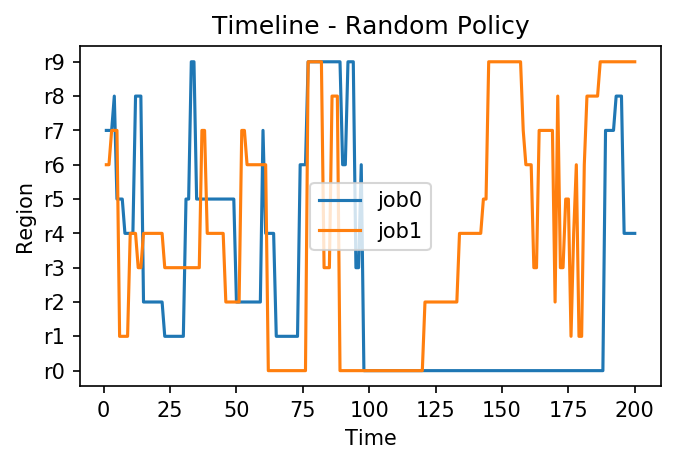

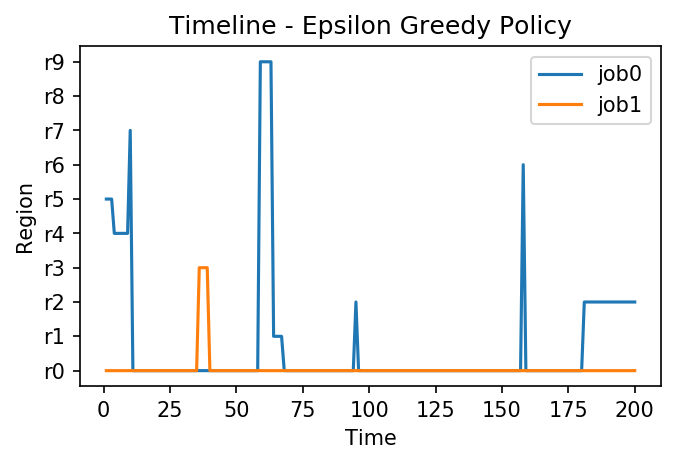

In [52]:
plot_timeline(random_env1.jobs, random_env1.regions)
plt.title("Timeline - Random Policy")

plot_timeline(eg_env1.jobs, eg_env1.regions)
plt.title("Timeline - Epsilon Greedy Policy")

Text(0.5, 1.0, 'Num preemptions - Epsilon Greedy Policy')

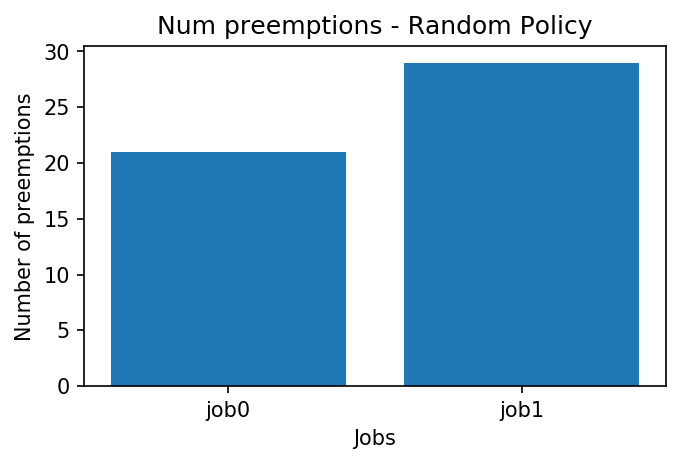

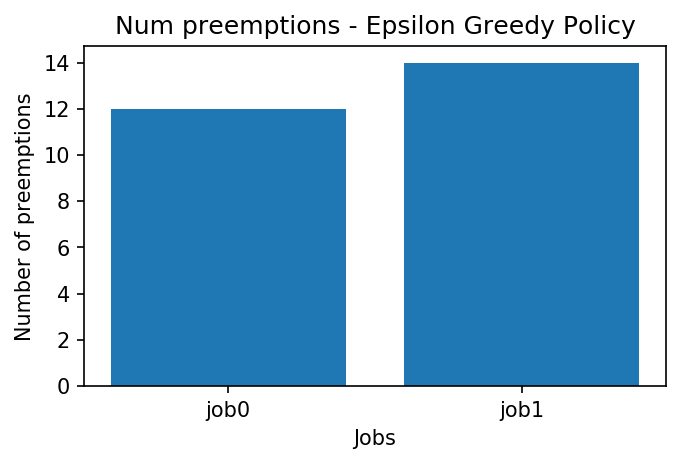

In [15]:
plot_num_preemptions(random_env1.jobs)
plt.title("Num preemptions - Random Policy")

plot_num_preemptions(eg_env1.jobs)
plt.title("Num preemptions - Epsilon Greedy Policy")
